In [1]:
# set working dir
import os
os.chdir("../")

In [2]:
from copy import deepcopy
from types import SimpleNamespace

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc

from run import utils

Auto-Sklearn cannot be imported.


In [3]:
# init config
config = SimpleNamespace()
config.prob = "sp"
config.grid = (5, 5)
config.feat = 5
config.net = []
config.optm = "adam"
config.l1 = 0.0
config.l2 = 0.0
config.rel = False
config.lan = "gurobi"
config.proc = 8
config.path = "./res"

In [4]:
# polynomial degree
degs = [1, 2, 4, 6]

In [5]:
def getPath(config, mthd):
    config = deepcopy(config)
    if mthd == "lr":
        config.mthd = "2s"
        config.pred = "lr"
    if mthd == "rf":
        config.mthd = "2s"
        config.pred = "rf"
    if mthd == "auto":
        config.mthd = "2s"
        config.pred = "auto"
        config.metric = "mse"
    if mthd == "spo":
        config.mthd = "spo"
        config.batch = 32
        config.lr = 1e-3
    if mthd == "bb":
        config.mthd = "bb"
        config.loss = "r"
        config.batch = 128
        config.lr = 1e-2
        config.smth = 20
    path = utils.getSavePath(config)
    return path

In [6]:
def getDf(config, degs, mthd):
    dfs = pd.DataFrame()
    for deg in degs:
        config.deg = deg
        df = pd.read_csv(getPath(config, mthd))
        dfs[deg] = df["Unamb SPO"]
    return dfs

In [7]:
def drawPlot(config, data, noise):
    # set config
    config = deepcopy(config)
    config.data = data
    config.noise = noise
    # color map
    cset =  tc.tol_cset('light')
    colors = [cset.mint, cset.pink, cset.pear, cset.orange, cset.light_blue]
    # get df
    df_lr    = getDf(config, degs, "lr")
    df_rf    = getDf(config, degs, "rf")
    df_auto  = getDf(config, degs, "auto")
    df_spo   = getDf(config, degs, "spo")
    df_bb    = getDf(config, degs, "bb")
    # draw boxplot
    fig = plt.figure(figsize=(16,6))
    c = colors[0]
    bp1 = plt.boxplot(df_lr, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo.shape[1])-0.38, widths=0.16)
    c = colors[1]
    bp2 = plt.boxplot(df_rf, boxprops=dict(facecolor=c, color=c, linewidth=4), 
                      medianprops=dict(color="w", alpha=0.9, linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo.shape[1])-0.19, widths=0.16)
    c = colors[2]
    bp3 = plt.boxplot(df_auto, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo.shape[1]), widths=0.16)
    c = colors[3]
    bp4 = plt.boxplot(df_spo, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2), 
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo.shape[1])+0.19, widths=0.16)
    c = colors[4]
    bp5 = plt.boxplot(df_bb, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2), 
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo.shape[1])+0.38, widths=0.16)
    # vertical line
    plt.axvline(x=0.5, color="k", linestyle="--", linewidth=1.5)
    plt.axvline(x=1.5, color="k", linestyle="--", linewidth=1.5)
    plt.axvline(x=2.5, color="k", linestyle="--", linewidth=1.5)
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # labels and ticks
    plt.xlabel("Polynomial Degree", fontsize=36)
    plt.xticks(ticks=[0,1,2,3], labels=[1,2,4,6], fontsize=28)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.yticks(fontsize=24)
    plt.xlim(-0.5, 3.5)
    plt.ylim(-0.02, 0.38)
    plt.title("Training Set Size = {},\nNoise Half−width = {}".format(config.data, config.noise), fontsize=30)
    plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0], bp5["boxes"][0]],
               ["2-stage LR", "2-stage RF", "2-stage Auto  ", "SPO+","DBB"], 
               fontsize=22, loc=2, labelspacing=0.2, handlelength=1, ncol=2)
    plt.show()
    fig.savefig("./images/sp-n{}e{}.pdf".format(data,int(10*noise)), dpi=300)

## n = 100, e = 0

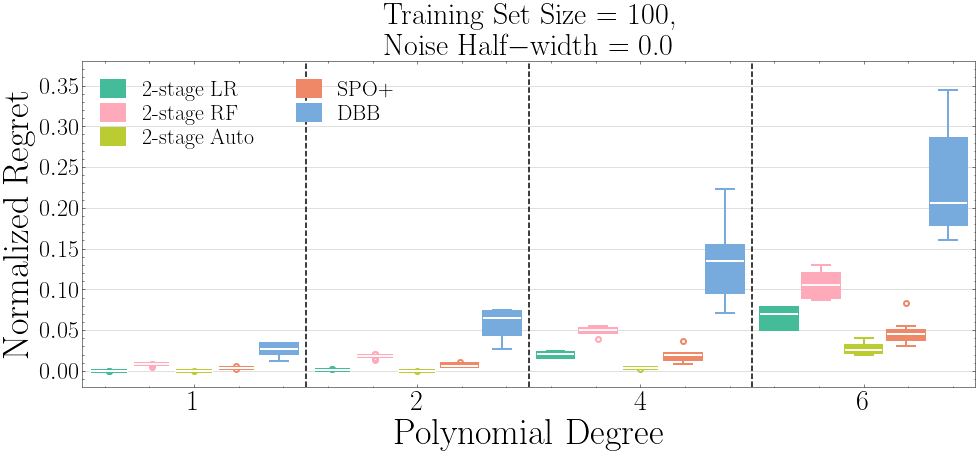

In [8]:
drawPlot(config, data=100, noise=0.0)

## n = 100, e = 0.5 

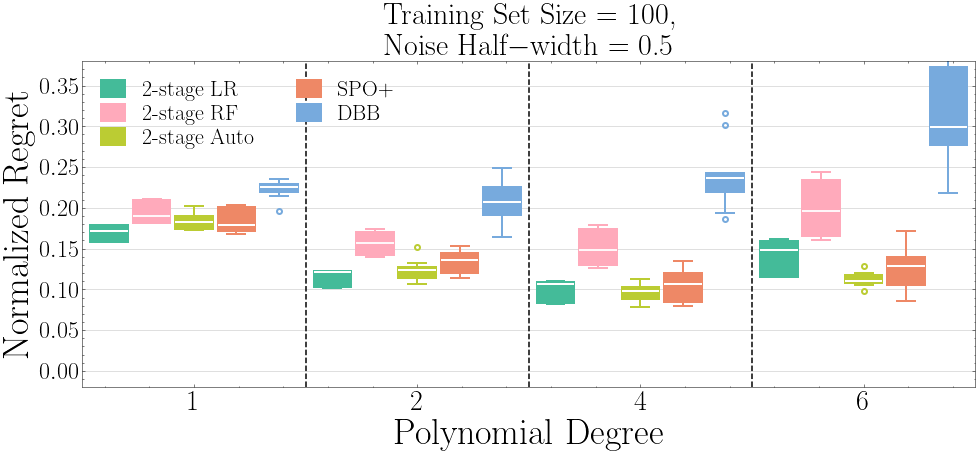

In [9]:
drawPlot(config, data=100, noise=0.5)

## n = 1000, e = 0

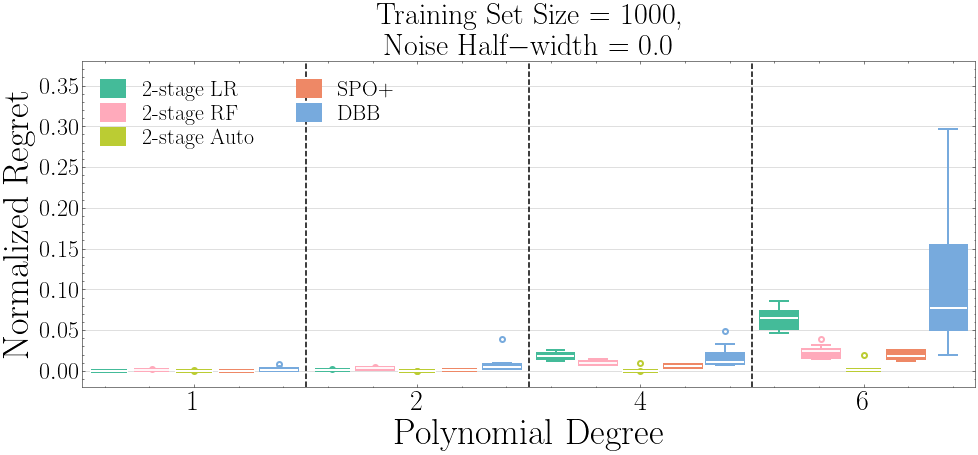

In [10]:
drawPlot(config, data=1000, noise=0.0)

## n = 1000, e = 0.5 

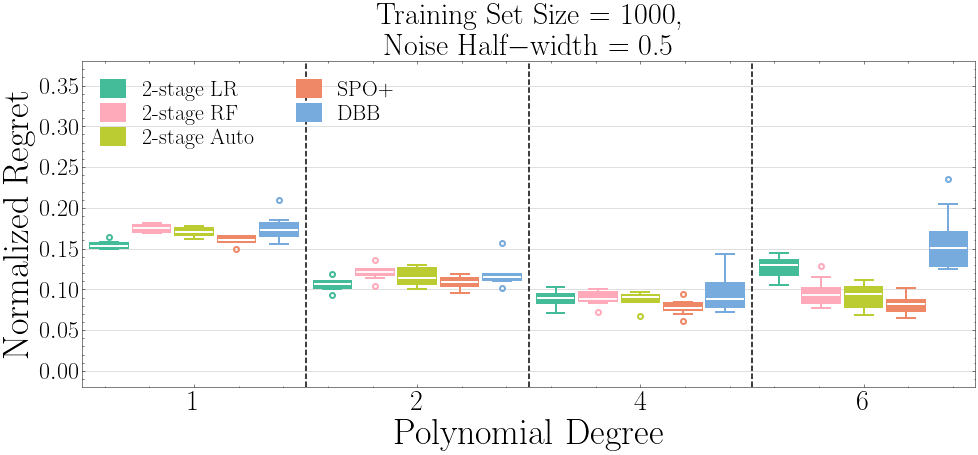

In [11]:
drawPlot(config, data=1000, noise=0.5)

## n = 5000, e = 0

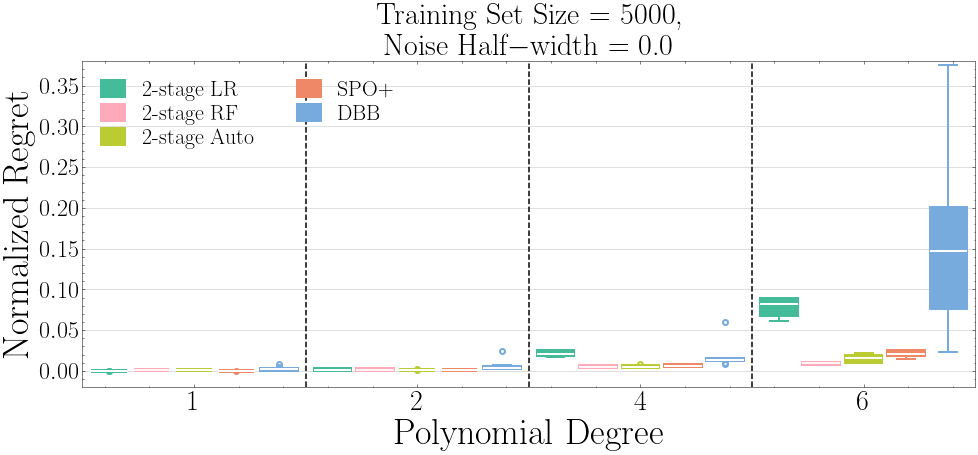

In [12]:
drawPlot(config, data=5000, noise=0.0)

## n = 5000, e = 0.5

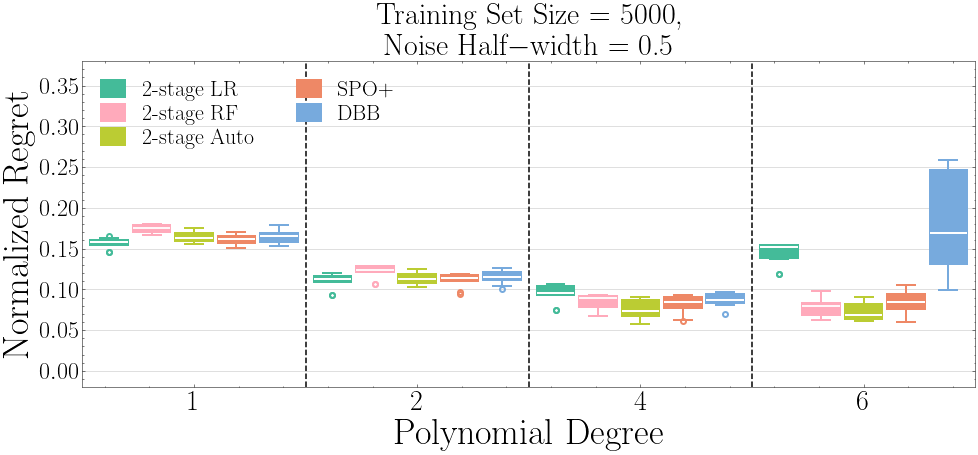

In [13]:
drawPlot(config, data=5000, noise=0.5)